In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import pickle
import datetime

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,BatchNormalization,GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.VGG16 import VGG16
#from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import load_model

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/CS331-BÁO CÁO"
TRAIN_PATH = os.path.join(ROOT_DIR, 'flowers_splited/train')
TEST_PATH = os.path.join(ROOT_DIR, 'flowers_splited/test')

In [ ]:
# splitfolders.ratio(DATASET_PATH,output=os.path.join(ROOT_DIR, 'flowers_splited'),seed=42,ratio=(.9, .1))

# Image Data Generators

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
target_size = (img_height, img_width)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        color_mode='rgb',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', 
    color_mode='rgb',
    subset='validation') 


test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        color_mode='rgb',
        shuffle=False)

Found 3107 images belonging to 5 classes.
Found 775 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [ ]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
class_weights

{0: 1.3763636363636365,
 1: 1.0,
 2: 1.3421985815602837,
 3: 1.433712121212121,
 4: 1.0692090395480225}

In [ ]:
print(train_generator.class_indices)
print(counter)
print(class_weights)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Counter({1: 757, 4: 708, 2: 564, 0: 550, 3: 528})
{0: 1.3763636363636365, 1: 1.0, 2: 1.3421985815602837, 3: 1.433712121212121, 4: 1.0692090395480225}


In [ ]:
counter_test = Counter(test_generator.classes)
max_val = float(max(counter_test.values()))

print(test_generator.class_indices)
print(counter_test)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Counter({1: 106, 4: 99, 2: 79, 0: 77, 3: 74})


In [ ]:
counter_val = Counter(validation_generator.classes)
max_val = float(max(counter_val.values()))

print(validation_generator.class_indices)
print(counter_val)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Counter({1: 189, 4: 177, 2: 141, 0: 137, 3: 131})


# Create Model

In [ ]:
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))

#for layer in base_model.layers[:(len(base_model.layers) // 3 * 2)]:
#   layer.trainable = False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, "-", layer.trainable)

94765736/94765736 [==============================] - 3s 0us/step
0 input_1 - True
1 conv1_pad - True
2 conv1_conv - True
3 conv1_bn - True
4 conv1_relu - True
5 pool1_pad - True
6 pool1_pool - True
7 conv2_block1_1_conv - True
8 conv2_block1_1_bn - True
9 conv2_block1_1_relu - True
10 conv2_block1_2_conv - True
11 conv2_block1_2_bn - True
12 conv2_block1_2_relu - True
13 conv2_block1_0_conv - True
14 conv2_block1_3_conv - True
15 conv2_block1_0_bn - True
16 conv2_block1_3_bn - True
17 conv2_block1_add - True
18 conv2_block1_out - True
19 conv2_block2_1_conv - True
20 conv2_block2_1_bn - True
21 conv2_block2_1_relu - True
22 conv2_block2_2_conv - True
23 conv2_block2_2_bn - True
24 conv2_block2_2_relu - True
25 conv2_block2_3_conv - True
26 conv2_block2_3_bn - True
27 conv2_block2_add - True
28 conv2_block2_out - True
29 conv2_block3_1_conv - True
30 conv2_block3_1_bn - True
31 conv2_block3_1_relu - True
32 conv2_block3_2_conv - True
33 conv2_block3_2_bn - True
34 conv2_block3_2_relu - 

In [ ]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

# Callbacks

In [ ]:
patience = 2
stop_patience = 3
factor = 0.5
callbacks = [
    ModelCheckpoint(os.path.join(ROOT_DIR, 'weights_model/ResNet50.h5'), save_best_only=True, save_weights_only=True, verbose=1),
    # EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=factor, patience=patience, verbose=1, min_lr=1e-6)
]

# Model Training

In [ ]:
epochs = 50
print(datetime.datetime.now())
history = model.fit(train_generator, validation_data=validation_generator, class_weight=class_weights, epochs=epochs, callbacks=callbacks, verbose=1)
print(datetime.datetime.now())

2022-11-09 09:14:31.142581
Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 1.2767 - accuracy: 0.6347
Epoch 1: val_loss improved from inf to 1.99065, saving model to /content/drive/MyDrive/CS331-BÁO CÁO/model/ResNet50.h5
98/98 [==============================] - 856s 9s/step - loss: 1.2767 - accuracy: 0.6347 - val_loss: 1.9907 - val_accuracy: 0.2439 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 0.9108 - accuracy: 0.7477
Epoch 2: val_loss did not improve from 1.99065
98/98 [==============================] - 63s 638ms/step - loss: 0.9108 - accuracy: 0.7477 - val_loss: 3.5821 - val_accuracy: 0.2439 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 0.9391 - accuracy: 0.7203
Epoch 3: val_loss improved from 1.99065 to 1.68395, saving model to /content/drive/MyDrive/CS331-BÁO CÁO/model/ResNet50.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
98/98 [==============================

In [ ]:
with open(os.path.join(ROOT_DIR, 'history_dict_ResNet50.pkl'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
model.evaluate(test_generator)

14/14 [==============================] - 2s 151ms/step - loss: 0.2582 - accuracy: 0.9057


[0.2582210898399353, 0.90574711561203]

In [ ]:
pickle_in = open(os.path.join(ROOT_DIR, 'history_dict_ResNet50.pkl'), "rb")
dict_log = pickle.load(pickle_in)

In [ ]:
dict_log.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

(0.0, 1.0)

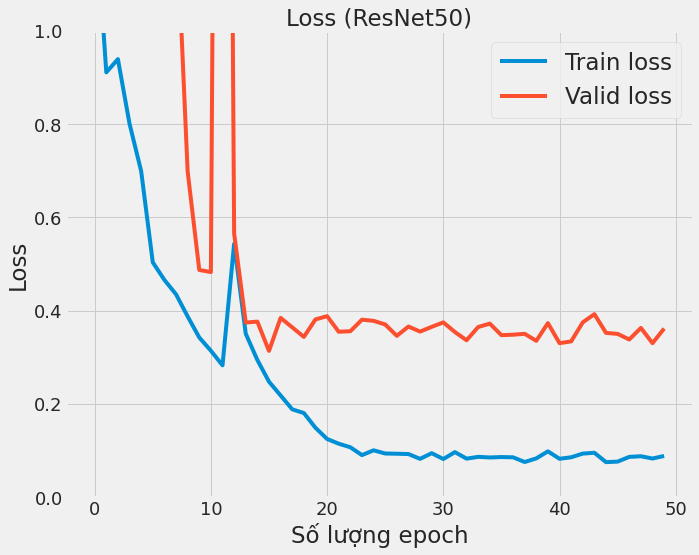

In [ ]:
plt.figure(figsize=(10, 8))
# plt.grid()


plt.plot(dict_log['loss'], label='Train loss')
plt.plot(dict_log['val_loss'], label='Valid loss')
plt.title('Loss (ResNet50)', fontsize=23)
plt.ylabel('Loss', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")


(0.8, 1.0)

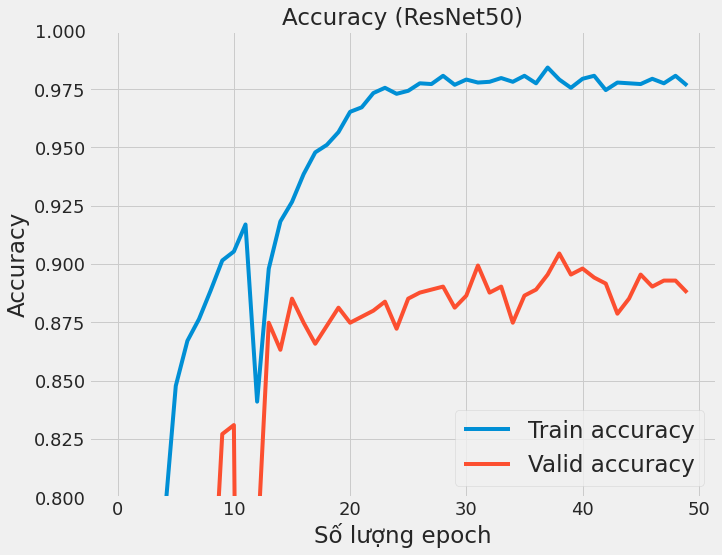

In [ ]:
plt.figure(figsize=(10, 8))
# plt.grid()


plt.plot(dict_log['accuracy'], label='Train accuracy')
plt.plot(dict_log['val_accuracy'], label='Valid accuracy')
plt.title('Accuracy (ResNet50)', fontsize=23)
plt.ylabel('Accuracy', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0.8, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")


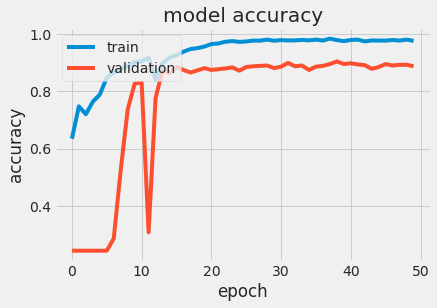

In [ ]:
plt.plot(dict_log['accuracy'])
plt.plot(dict_log['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-2.png")
plt.show()

# Predictions on Test Set

In [ ]:
best_model = model
best_model.load_weights(os.path.join(ROOT_DIR, 'weights_model/ResNet50.h5'))

In [ ]:
best_model.evaluate(test_generator)

14/14 [==============================] - 143s 10s/step - loss: 0.2582 - accuracy: 0.9057


[0.2582210898399353, 0.90574711561203]

In [ ]:
preds = best_model.predict(test_generator)

14/14 [==============================] - 3s 192ms/step


In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]

    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir, dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      

    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    

    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
            
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig1=plt.figure()
        fig1.set_figheight(len(plot_class)/3)
        fig1.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        fig2 = plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix (ResNet50)")
        # plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-4.png", dpi = 100)
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

        # fig1.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-3.png", dpi = 100)

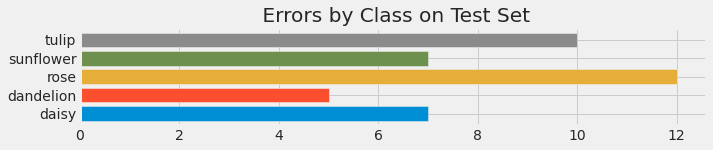

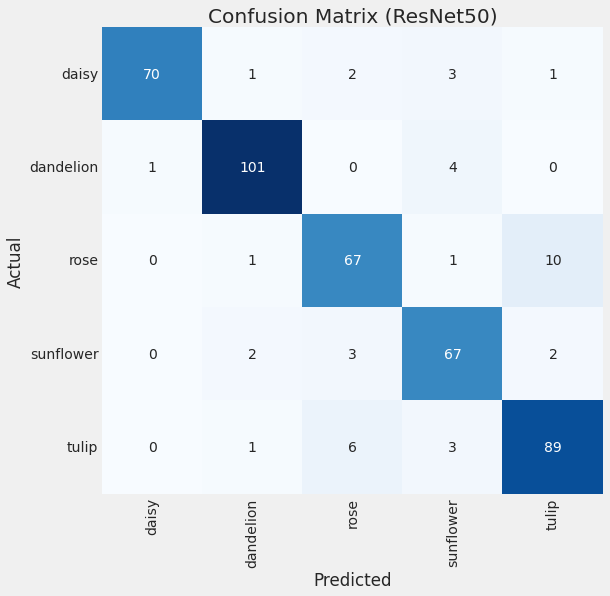

Classification Report:
----------------------
               precision    recall  f1-score   support

       daisy       0.99      0.91      0.95        77
   dandelion       0.95      0.95      0.95       106
        rose       0.86      0.85      0.85        79
   sunflower       0.86      0.91      0.88        74
       tulip       0.87      0.90      0.89        99

    accuracy                           0.91       435
   macro avg       0.91      0.90      0.90       435
weighted avg       0.91      0.91      0.91       435



In [ ]:
save_dir = ''
subject = "kq"
print_code = 0
print_info(test_generator, preds, print_code, save_dir, subject)